In [1]:
#!/usr/bin/env python3
# coding: utf-8
""" Usage:
    python3 thai-student-stat.py directory
"""

' Usage:\n    python3 thai-student-stat.py directory\n'

In [2]:
import glob
import tgt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import edit_distance

VOWELS=['i', 'y', 'u', 'ɨ', 'ɤ', 'e', 'ɛ', 'ə', 'o',  'ɔ',  'a', 'ɚ']
CONSONS= ['p', 'pʰ', 't', 'tʰ', 'k', 'kʰ', 'ts', 'tsʰ', 'tʂ', 'tʂʰ', 'tɕ', 'tɕʰ', 'f', 'ɕ', 'x', 's', 
          'ʂ', 'ʐ', 'm', 'n', 'ŋ', 'l', 'ɥ', 'j', 'w']
LABELS = VOWELS+CONSONS
#print(CONSONS)

In [3]:
def tiername(txtgridr):
    txtlist = glob.glob(txtgridr+"/*.12")
    for txtgridf in txtlist:
        tg = tgt.io.read_textgrid(txtgridf, encoding='utf-8', include_empty_intervals=True)
        txrs = tg.get_tier_names()
        print(txrs)

In [4]:
def contains_chinese(check_str):
    """
    判断字符串中是否包含中文
    :param check_str: {str} 需要检测的字符串
    :return: {bool} 包含返回True， 不包含返回False
    """
    for ch in check_str:
        if u'\u4e00' <= ch <= u'\u9fff':
            return True
    return False

def all_chinese(check_str):
    for ch in check_str:
        if not (u'\u4e00' <= ch <= u'\u9fff'):
            return False
    return True

In [5]:
def fdistance(S1,S2):
    a = len(S1)
    b = len(S2)
    fdn = {} # Global dict

    for x in range(a+1):
        for y in range(b+1):
            fdn[x,y] = 0
    
    for x in range(a+1):
        fdn[x,0] = x
    for y in range(b+1):
        fdn[0,y] = y

    print(fdn)
    for x in range(1,a+1):
        for y in range(1,b+1):
            if S1[x-1] == S2[y-1]: 
                c = 0 
            else:
                c = 1
            minc = min(fdn[x,y-1]+1, fdn[x-1,y]+1, fdn[x-1,y-1]+c)

    return fdn[x,y]

In [6]:
def substCost(x,y):
    if x == y: 
        return 0
    else: 
        return 1

def levenshtein(target, source):
    i = len(target)
    j = len(source)
    if i == 0:  
        return j
    elif j == 0: 
        return i

    return(min(levenshtein(target[:i-1],source)+1,
               levenshtein(target, source[:j-1])+1,
               levenshtein(target[:i-1], source[:j-1])+substCost(source[j-1],target[i-1])))

In [7]:
def opprint(t, s, op):
    for tag, i1, i2, j1, j2 in op:
        print('{:7}   a[{}:{}] --> b[{}:{}] {!r:>8} --> {!r}'.format(tag, i1, i2, j1, j2, t[i1:i2], s[j1:j2]))

In [8]:
def list_gen_and_plot(tplist, splist, TEMPL, Title):
    #print(Title, tplist, splist)
    vtplist = []
    vsplist = []
    for i in range(len(tplist)):
        if tplist[i] in TEMPL:
            #print("<",tplist[i], splist[i],">")
            vtplist.append(tplist[i])
            vsplist.append(splist[i])
    mat = confusion_matrix(vtplist, vsplist, labels=TEMPL)
    df_cm = pd.DataFrame(mat, index = TEMPL, columns = TEMPL)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True,cmap="OrRd",fmt="d")
    plt.title(Title)
    plt.xlabel("Incorrect")
    plt.ylabel("Correct")
    plt.show()

In [9]:
def stat_main(txtgridr):
    #print(txtgridr)
    txtlist = glob.glob(txtgridr+"/*.12")
    print("File list", txtlist)
    for txtgridf in txtlist:
        tg = tgt.io.read_textgrid(txtgridf, encoding='utf-8', include_empty_intervals=True)
        t3=tg.get_tier_by_name('word')
        t6=tg.get_tier_by_name('IU/phone')
        t10=tg.get_tier_by_name('EU/phone')

        tplist=[]
        splist=[]
        for i in t3:
            t = i.text.replace(' ','').replace('*','').replace('^','')
            item6 = t6.get_annotations_between_timepoints(i.start_time, i.end_time, left_overlap=True, right_overlap=True)
            item10 = t10.get_annotations_between_timepoints(i.start_time, i.end_time, left_overlap=True, right_overlap=True)

            if (len(item6) != len(item10)):
                print("Length diff", i, t)
            else:
                for tt, ss in zip(item6, item10):
                    try:
                        tstr = tt.text.replace(' ','')
                        sstr = ss.text.replace(' ','')
                        #f tstr != sstr:
                        #   print('[',tt.text,'][', ss.text, ']')                        
                        tplist.append(tstr)
                        splist.append(sstr)
                    except:
                        print('Exception')

        list_gen_and_plot(tplist, splist, VOWELS, txtgridf[6:10])
        list_gen_and_plot(tplist, splist, CONSONS, txtgridf[6:10])
    #print(tcvlist, scvlist)
    #list_gen_and_plot(tcvlist, scvlist, ["C","V","G","N"])

File list ['extra\\Indonesian_3_009.TextGrid.12', 'extra\\Thai_3_002.TextGrid.12', 'extra\\Vietnamese_3_011.TextGrid.12']
Length diff Interval(6.666682439731487, 6.853653818116241, "然 * 後 *") 然後
Length diff Interval(17.757832752834556, 17.952862053581857, "時 * 候 *") 時候
Length diff Interval(19.9462326332503, 20.18729369442243, "喜歡 * ^") 喜歡
Length diff Interval(21.239333816232506, 21.379851821739877, "我 *") 我


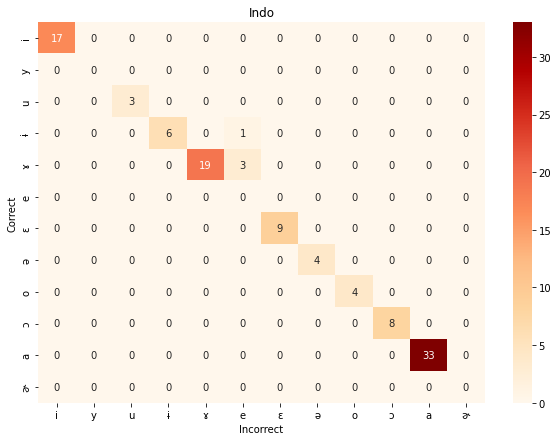

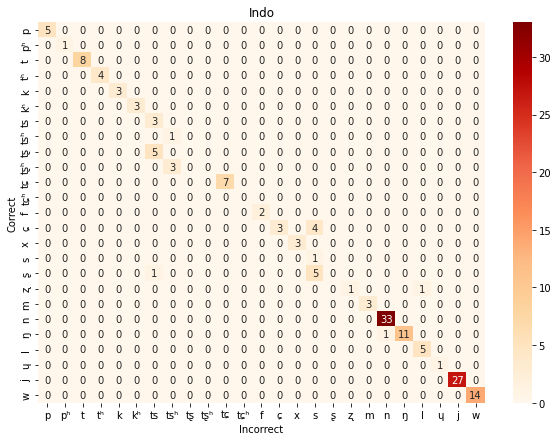

Length diff Interval(10.9825, 11.3225, "人 *") 人
Length diff Interval(14.792725796922653, 15.195551433059444, "人 ^ * 們 ^ *") 人們
Length diff Interval(16.8325, 17.232499999999998, "但 ^ 是 *") 但是
Length diff Interval(17.816746019992046, 18.03395308710893, "人 *") 人
Length diff Interval(20.140538211281413, 20.655603639555668, "家 ^ 人 *") 家人
Length diff Interval(22.032048742046353, 22.46887753208109, "給 *") 給
Length diff Interval(23.36878745049558, 23.58040733145977, "給 * ^") 給
Length diff Interval(24.455884564414397, 24.868151443626118, "他 ^ 們 * ^") 他們


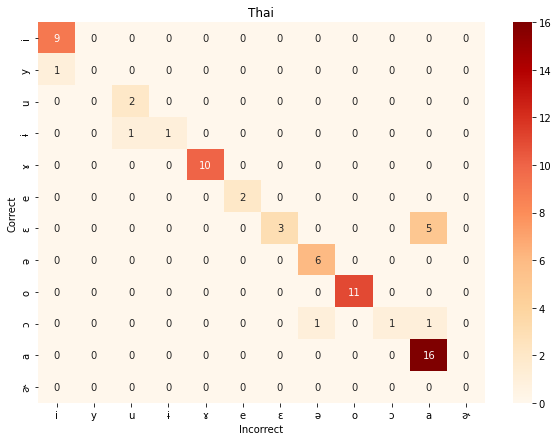

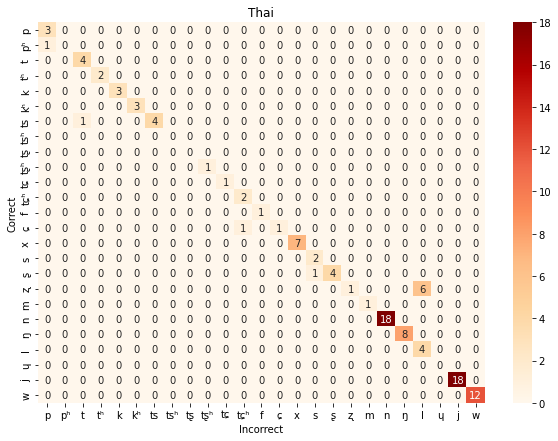

Length diff Interval(12.99886526390921, 13.103990113498794, "我 *") 我
Length diff Interval(25.634710362904535, 26.19376676088562, "空 ^ 間 ^") 空間


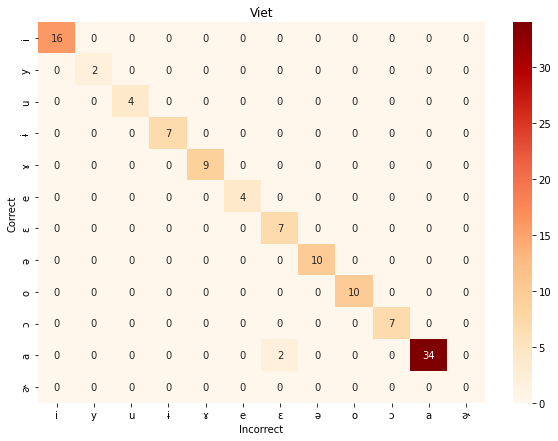

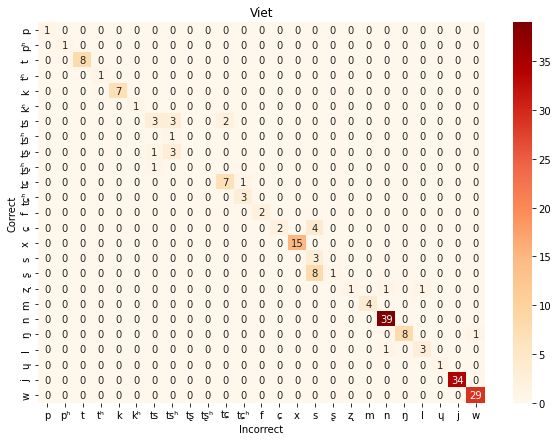

In [10]:
stat_main('extra')